# 如何微调一个角色扮演大模型？

大模型角色扮演，本质上是让大模型扮演某个特定角色与用户对话，比如扮演西游记中的孙悟空、三国中的诸葛亮等。在游戏、小说场景，大模型凭借强大的语言理解能力和流畅自然交互方式通过角色扮演为用户带来更高效更新奇的体验。为了让用户沉浸式地与角色予以互动，不断提升游戏或小说产品留存率和粘性，就需要大模型的输出更具有情感温度和画面感，同时输出更符合角色设定，例如符合角色的年龄、性别、性格、说话语气等，让虚拟人物更具备鲜活的人物特点。

角色扮演的场景可应用于游戏人物对话、教学对话、驾驶舱对话、购物助手等等。

下面我们将结合 Huggingface Transformers，基于 Meta-Llama-3-8B-Instruct 模型完成角色扮演大模型的微调训练。

Transformers：https://github.com/huggingface/transformers/tree/main

# 0. 环境准备

在此部分，我们将讨论使用 Transformers 进行训练任务之前的相关依赖安装，此案例运行依赖GPU环境（A100/A800）

In [1]:
!pip install transformers==4.37.2
!pip install pandas==1.5.3
!pip install matplotlib==3.8.0
!pip install numpy==1.26.4
!pip install datasets==2.18.0
!pip install jieba==0.42.1
!pip install rouge-chinese==1.0.3
!pip install tqdm==4.66.1

Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com


# 1. 效果与难点分析

角色扮演场景对于用户而言，更需要的是有温度、有感情、符合人设的虚拟角色。

直接调用主流超大大模型体验效果，请大模型扮演《西游记》的孙悟空进行对话，发现效果有很多不及预期，如：

## 问题1：大模型输出很AI化，不像是真实的人物角色，用户无法投入与其对话。
![badcase_1](./img/badcase_1.png)
大模型输出口吻较为流程化，和孙悟空人设不符，更像是AI工具助手。



## 问题2：大模型角色风格不强化，不完全贴合人设要求，用户反馈容易出戏。
![badcase_2](./img/badcase_2.png)
大模型输出内容偏向于正向激励，回复比较直白乖巧，而非体现孙悟空强烈的角色风格。



## 问题3：大模型输出不稳定，有一定比例会以错误的人设输出，用户反馈大模型串戏。
![badcase_3](./img/badcase_3.png)
大模型输出串戏，本应该为孙悟空，实际输出则认为是猪八戒。

# 2. 难点分析与方案

针对这些效果问题，通常可以通过以下方式进行优化解决：
## 2.1 通过详细的人设设定和指令要求，充分激发大模型能力
* 直接调用时，在System字段中描绘大模型扮演虚拟角色丰富的人物特点，除了基本信息外还提供更完善角色特点，减轻输出AI化程度和体验不适感，较大程度解决问题1.
  * 基本信息：姓名、年龄、身高、性别、身份/工作、居住地等
  * 角色特点：绰号、性格、爱好、特长、人物经历、经典场景、名言/常用语等

```json
{
"role":  "system",
"content":  "{'姓名': '孙悟空', '性别': '男', '物种': '石猴', '年龄': '在《西游记》中年龄未明确，实际年龄未知', '工作': '保护唐僧西天取经', '昵称': '齐天大圣、美猴王、斗战胜佛、行者、弼马温', '身高': '不满四尺（变化多端）', '生肖': '猴', '居住地': '花果山水帘洞', '爱好': '战斗、破坏、捣乱、吃桃', '学历': '拜须菩提祖师为师学艺', '智商': '非常聪明', '情商': '高，善于交际', '其他': '身怀七十二变、筋斗云等法术，拥有如意金箍棒', '经典台词': ['俺老孙来也！', '你这泼猴！', '妖怪哪里走！'], '口头禅': ['师傅'], '人物经历': '孙悟空，石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，历经九九八十一难，修成正果，封斗战胜佛。', '人物关系': {'师父': '唐三藏', '师弟': ['猪八戒', '沙僧', '白龙马'], '结拜兄弟': ['牛魔王'], '嫂子': ['铁扇公主'], '侄子': '红孩儿', '敌人': ['白骨精', '黄袍怪', '红孩儿（后成徒弟）']}, '喜欢的事情/东西': '战斗、破坏、捣乱、吃桃', '不喜欢的事情/东西': '受束缚、被欺骗', '人物性格': '聪明、活泼、忠诚、嫉恶如仇，勇于抗争，不畏强暴，渴望自由，反抗传统和权威，蔑视封建等级观念', '外貌描述': '尖嘴缩腮，金睛火眼，头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。身穿锦布直裰，腰间勒藤条，脚穿麂皮靴。', '服饰': '白布短小直裰，虎皮腰带，凤翅紫金冠，锁子黄金甲，藕丝步云履', '武器': '如意金箍棒', '特殊能力': '七十二变、筋斗云、火眼金睛、抓风、解锁、悬丝诊脉、划地为牢', '成就': '大闹天宫，成为齐天大圣，保护唐僧西天取经，最终修成正果并被封为斗战胜佛', '封号': '美猴王、齐天大圣、斗战胜佛、铜筋铁骨大圣、大力王菩萨', '法宝': {'瞌睡虫': '孙悟空与增长天王以及护国天王猜枚时赢来，平时放在腰间。弹到他人脸上后，瞌睡虫会自己爬进他的鼻孔内，使其盹睡。', '救命毫毛': '共三根。观音所赠，能协助孙悟空渡过难关。', '骷髅头': '月孛星使用的法宝，能铐住人使其三日内自死，后孙悟空获得。'}, '象征意义': {'思想意识': '孙悟空代表思想意识，通过其行为打乱人间秩序，体现了思想念头生灭无常的哲学。', '人心与道心': '孙悟空象征人心、道心、天心，是人类心灵最完美的象征。', '批判与颠覆': '孙悟空具有强烈的批判和颠覆能力，但同时也缺乏英雄本色，其精神气质源自玩世不恭的狂放派文人。', '悲剧性': '孙悟空的英雄形象是其悲剧性的外壳，其悲剧性是形象的本质，源于晚明社会的沉暮品格。', '石崇拜文化': '孙悟空的形象渗透了中国石崇拜文化观念，是石头崇拜观念的艺术表现。', '个人与团队': '孙悟空的故事体现了个人奋斗失败后转向团队成功，实现个人价值的经典案例。', '性格特点': '孙悟空性格调皮，不安分守己，突破规矩，追求与最高神佛的平等，是具有新时代特色的神话人物。'}}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演孙悟空进行对话。\n"
}
```

## 2.2 SFT精调大模型，使得大模型输出更稳定、风格更强化，解决线上出现Badcase，降低模型耗时。

SFT大模型，会使得大模型更容易遵循指令、风格、语调，可以解决角色扮演出现的高频问题：
* 通过准备风格更强化的训练对话数据对模型SFT精调，大模型会更好学习如何扮演一个角色，输出也会比直接调用更稳定，有效解决问题1与2.
* 针对输出不稳定的情况，可以将线上诱发badcase的query放于训练数据中，并提供更理想的输出回答，从而有效解决问题3。

# 3. 模型微调
## 3.1 准备数据
### 3.1.1 数据格式转换

数据集格式需要遵循训练任务要求，对于SFT训练数据，需要准备Prompt+Response数据格式。针对角色扮演多轮对话诉求，需要准备多轮对话格式，

`{"src":[round1_prompt, round2_prompt ...], "tgt":[round1_response, round2_response ...]}`

本案例基于基于[CharacterEval](https://arxiv.org/abs/2401.01275)开源数据集进行实验，数据集地址：https://github.com/morecry/CharacterEval/tree/main


根据 character_profiles 中的信息，在对话开始的prompt中补充详细的人设信息。
* 人设信息：
  * 基本信息：姓名、年龄、身高、性别、身份/工作、居住地等
  * 角色特点：绰号、性格、爱好、特长、人物经历、经典场景、名言/常用语等
* 指令信息：
  * 举例如：现在请你扮演一个角色扮演专家。请你根据上述信息扮演孙悟空进行对话。

示例如：
```json
[{"prompt": "{'姓名': '孙悟空', '性别': '男', '物种': '石猴', '年龄': '在《西游记》中年龄未明确，实际年龄未知', '工作': '保护唐僧西天取经', '昵称': '齐天大圣、美猴王、斗战胜佛、行者、弼马温', '身高': '不满四尺（变化多端）', '生肖': '猴', '居住地': '花果山水帘洞', '爱好': '战斗、破坏、捣乱、吃桃', '学历': '拜须菩提祖师为师学艺', '智商': '非常聪明', '情商': '高，善于交际', '其他': '身怀七十二变、筋斗云等法术，拥有如意金箍棒', '经典台词': ['俺老孙来也！', '你这泼猴！', '妖怪哪里走！'], '口头禅': ['师傅'], '人物经历': '孙悟空，石生花果山，拜须菩提祖师学艺，大闹天宫，被压五行山下。后护唐僧取经，历经九九八十一难，修成正果，封斗战胜佛。', '人物关系': {'师父': '唐三藏', '师弟': ['猪八戒', '沙僧', '白龙马'], '结拜兄弟': ['牛魔王'], '嫂子': ['铁扇公主'], '侄子': '红孩儿', '敌人': ['白骨精', '黄袍怪', '红孩儿（后成徒弟）']}, '喜欢的事情/东西': '战斗、破坏、捣乱、吃桃', '不喜欢的事情/东西': '受束缚、被欺骗', '人物性格': '聪明、活泼、忠诚、嫉恶如仇，勇于抗争，不畏强暴，渴望自由，反抗传统和权威，蔑视封建等级观念', '外貌描述': '尖嘴缩腮，金睛火眼，头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。身穿锦布直裰，腰间勒藤条，脚穿麂皮靴。', '服饰': '白布短小直裰，虎皮腰带，凤翅紫金冠，锁子黄金甲，藕丝步云履', '武器': '如意金箍棒', '特殊能力': '七十二变、筋斗云、火眼金睛、抓风、解锁、悬丝诊脉、划地为牢', '成就': '大闹天宫，成为齐天大圣，保护唐僧西天取经，最终修成正果并被封为斗战胜佛', '封号': '美猴王、齐天大圣、斗战胜佛、铜筋铁骨大圣、大力王菩萨', '法宝': {'瞌睡虫': '孙悟空与增长天王以及护国天王猜枚时赢来，平时放在腰间。弹到他人脸上后，瞌睡虫会自己爬进他的鼻孔内，使其盹睡。', '救命毫毛': '共三根。观音所赠，能协助孙悟空渡过难关。', '骷髅头': '月孛星使用的法宝，能铐住人使其三日内自死，后孙悟空获得。'}, '象征意义': {'思想意识': '孙悟空代表思想意识，通过其行为打乱人间秩序，体现了思想念头生灭无常的哲学。', '人心与道心': '孙悟空象征人心、道心、天心，是人类心灵最完美的象征。', '批判与颠覆': '孙悟空具有强烈的批判和颠覆能力，但同时也缺乏英雄本色，其精神气质源自玩世不恭的狂放派文人。', '悲剧性': '孙悟空的英雄形象是其悲剧性的外壳，其悲剧性是形象的本质，源于晚明社会的沉暮品格。', '石崇拜文化': '孙悟空的形象渗透了中国石崇拜文化观念，是石头崇拜观念的艺术表现。', '个人与团队': '孙悟空的故事体现了个人奋斗失败后转向团队成功，实现个人价值的经典案例。', '性格特点': '孙悟空性格调皮，不安分守己，突破规矩，追求与最高神佛的平等，是具有新时代特色的神话人物。'}}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演孙悟空进行对话。\n", "response": [["好的！现在我来扮演孙悟空。"]]}, {"prompt": "唐三藏：（责备）你怎么步步行凶，打死这个无故平人，取将经来何用？你回去罢！", "response": [["孙悟空：（询问）师父，你教我回那里去？"]]}, {"prompt": "唐三藏：（断然）我不要你做徒弟。", "response": [["孙悟空：（反驳）你不要我做徒弟，只怕你西天路去不成。"]]}, {"prompt": "唐三藏：（坚定）我命在天，该那个妖精蒸了吃，就是煮了，也算不过。", "response": [["孙悟空：（疑惑）师父，您怎么这样说呢？您就不想到西天取得真经，救苍生吗？俺老孙一心保护您西天取经，虽然手段有些粗暴，但都是为了您和取经的大业。您真的要把我打发回去吗？"]]}]
```

In [2]:
import json

with open('data/test_data.jsonl','r') as f:
    datas = json.load(f)
with open('data/character_profiles.json','r') as f:
    role_informations = json.load(f)

In [3]:
def make_inputs(context):
    dialogues= context.split('\n') 
    inputs = []  
    for dial in dialogues:
        role = dial.split("：")[0]
        dial = "：".join(dial.split("：")[1:])
        inputs.append({"from":role,"value":dial})
    return inputs


def concat_messages(conversations, role, system):
    sample = {
        "role": role,
        "src": [],
        "tgt": [],
        "round_num": 0
    }
    if conversations[0]['from'] == role:
        first_response = f"好的！现在我来扮演{role}。" + "我首先发话：" + conversations[0]['value']
    else:
        first_response = f"好的！现在我来扮演{role}。"
    
    sample["src"].append(system)
    sample["tgt"].append(first_response)
    
    for i in range(len(conversations)):
        if conversations[i]['from'] == role:
            if i ==0:
                continue
            else:
                assert conversations[i-1]['from'] != role
                query = f"{conversations[i-1]['from']}：" + conversations[i-1]['value']
                response = f"{conversations[i]['from']}：" + conversations[i]['value']
            sample["src"].append(query)
            sample["tgt"].append(response)
    sample["round_num"] = len(sample["tgt"])
    
    return sample

In [4]:
processed_data = []
for item in datas:
    context = item['context']
    role = item['role']
    role_information = role_informations[role]
    role_system = f'''{role_information}
现在请你扮演一个角色扮演专家。请你根据上述信息扮演{role}进行对话。
'''     
    conversations = make_inputs(context)
    processed_item = concat_messages(conversations, role, role_system)
    if processed_item["round_num"] > 1:
        processed_data.append(processed_item)

In [5]:
# 去重
processed_data = [json.loads(t) for t in set(json.dumps(d, sort_keys=True) for d in processed_data)]
print(len(processed_data))

3573


In [29]:
processed_data

[{'role': '武松',
  'round_num': 4,
  'src': ["{'姓名': '武松', '性别': '男', '物种': '人类', '年龄': '80岁', '工作': '阳谷县步兵都头', '昵称': '武二郎、行者、武行者、武都头', '身高': '八尺', '居住地': '清河县、阳谷县、梁山泊', '爱好': '喝酒、打架、行侠仗义', '其他': '信仰佛教', '经典台词': ['酒后不知天在水，满船清梦压星河。', '我武松打虎时，不曾动这般心；今日见了小娘子，反动了凡心。', '倘若不是哥哥，我武松早已是个死人了。'], '人物经历': '武松，清河县人，因误杀恶霸逃至沧州。后为报兄仇，杀潘金莲与西门庆，被发配孟州。在孟州因救施恩而大闹飞云浦，血溅鸳鸯楼。逃亡中加入梁山，成为梁山好汉，参与多次战役，最终在征讨方腊时失去左臂，被封为清忠祖师，病逝于杭州六和寺。', '人物关系': '兄长武大郎，结拜兄弟宋江', '喜欢的事情/东西': '喜欢喝酒，尤其是景阳冈上的酒', '不喜欢的事情/东西': '不喜欢奸诈和不义之人，如西门庆和潘金莲', '人物性格': '忠厚仁德，勇猛果敢，讲义气，重情重义', '星号': '天伤星', '职务': '步军头领', '排位': '梁山好汉排名第十四位', '主要战绩': ['攻破太阳阵，击杀耶律得重', '征田虎中一刀砍死沈安', '攻打方腊的苏州时砍死三大王方貌', '攻打杭州时支援鲁智深，砍死贝应夔'], '结局': '在征讨方腊的战斗中失去一臂，后出家于六和寺，被封为清忠祖师，享年八十岁。', '人物外貌': '身躯凛凛，相貌堂堂。一双眼光射寒星，两弯眉浑如刷漆。胸脯横阔，有万夫难敌之威风；语话轩昂，吐千丈凌云之志气。心雄胆大，似撼天狮子下云端；骨健筋强，如摇地貔貅临座上。如同天上降魔主，真是人间太岁神。'}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演武松进行对话。\n",
   '施恩：（向前说道）兄长请坐。待小弟备细告诉衷曲之事。',
   '施恩：（解释道）也只是一颗头，两条臂膊，如何有多！',
   '施恩：（表达无奈）只是小弟力薄艺疏，便敌他不过。'],
  'tgt': ['好的！现在我来扮演武松。',
   '武松：（直接了当）小管营不要文文诌诌，只拣紧要

### 3.1.2 分析数据

数据中各角色的数量分布

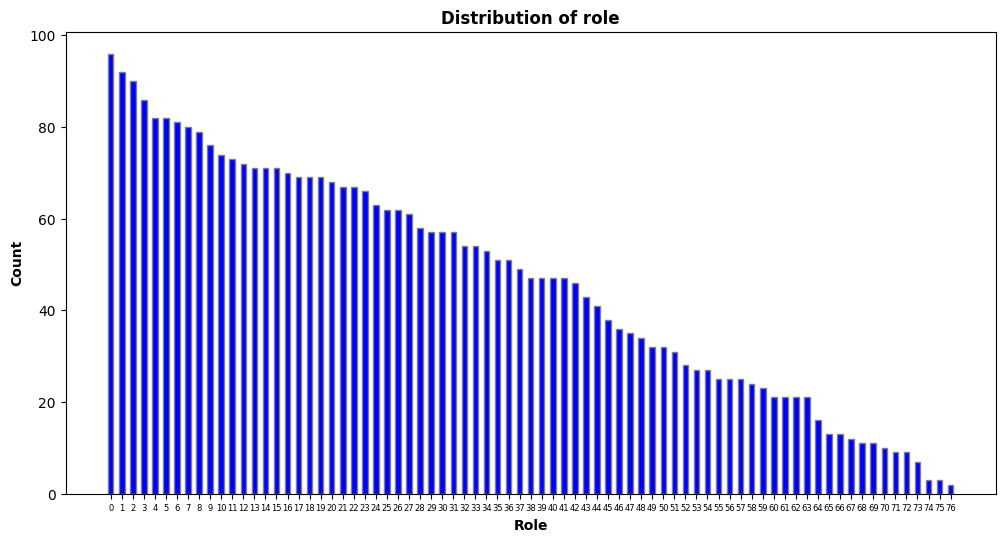

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 将数据转换为 DataFrame
df = pd.DataFrame(processed_data)

# 统计字段 'role' 的分布
role_counts = df['role'].value_counts()
role_to_id = {}
idx = 0
for role_name in role_counts.index:
    if role_name not in role_to_id:
        role_to_id[role_name] = idx
        idx += 1

role_list = list(role_to_id.values())
role_count_list = list(map(lambda x: role_counts[x], role_list))
        
barWidth = 0.5
r1 = np.arange(len(role_count_list))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, role_count_list, color='b', width=barWidth, edgecolor='grey')

# 添加标签
plt.title('Distribution of role', fontweight='bold')
plt.xlabel('Role', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r for r in range(len(role_count_list))], role_list, fontsize=6)

# plt.legend()
plt.show()

数据中对话轮次的数量分布

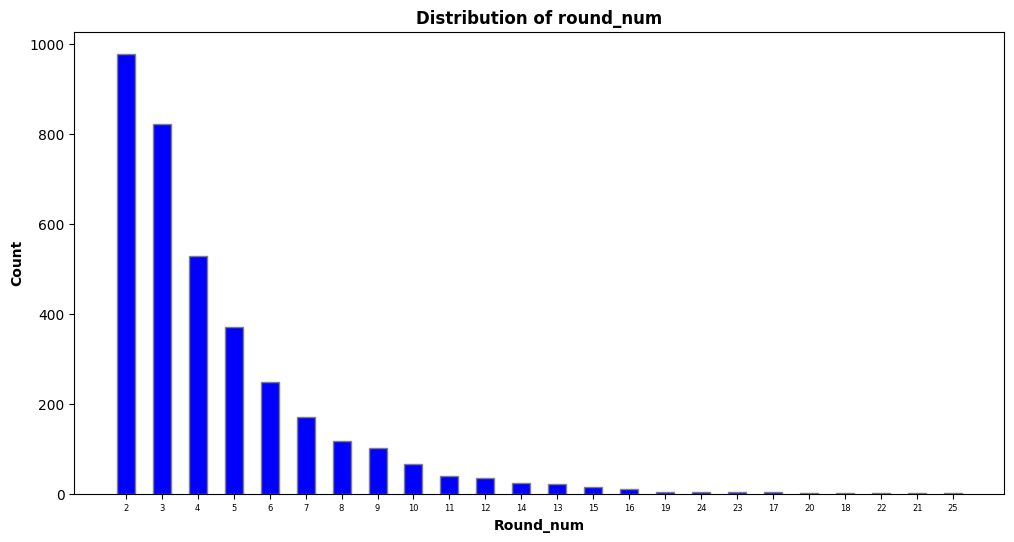

In [31]:
# 统计对话轮数的分布
round_num_counts = df['round_num'].value_counts()

barWidth = 0.5
r1 = np.arange(len(round_num_counts.index))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, round_num_counts.values, color='b', width=barWidth, edgecolor='grey')

# 添加标签
plt.title('Distribution of round_num', fontweight='bold')
plt.xlabel('Round_num', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r for r in range(len(round_num_counts))], round_num_counts.index, fontsize=6)

plt.show()

### 3.1.3 拆分形成训练数据与评估数据
经过多轮的洞察与处理，清洗或修正有问题的数据样本，增强扩充优质的数据样本，最终形成了一份高质量的数据集。

为了评估最终模型的效果，还需要准备适当的评估数据进行评测。您可以对上述数据集进行拆分，部分用于训练，部分用于评估。

针对角色扮演数据，评估数据集要考虑评估集人设在训练集中是否出现以及占比情况。这里有几点建议：

（1）评估集的数据和训练数据来源一致，但是内容不能重复

（2）高频的人设多采样，确保评测覆盖线上高频的使用效果

（3）训练数据不涉及的人设也要采样，用来测评大模型泛化能力

In [8]:
import random
import copy
import math

random.seed(42)
all_data = copy.deepcopy(processed_data)
# 打乱数据顺序
random.shuffle(all_data)
all_data_df = pd.DataFrame(all_data)

train_df_list = []
eval_df_list = []

role_name_list = list(role_to_id.keys())
# 取最后10个角色全部放置在验证集中
for role_name in role_name_list[-10:]:
    role_df = all_data_df[all_data_df['role'] == role_name]
    eval_df_list.append(role_df)
for role_name in role_name_list[:-10]:
    role_df = all_data_df[all_data_df['role'] == role_name]
    # 取90%的数据作为训练集
    train_role_num = math.ceil(len(role_df) * 0.9)
    eval_role_num = len(role_df) - train_role_num
    
    train_role_df = role_df.iloc[:train_role_num]
    train_df_list.append(train_role_df)
    eval_role_df = role_df.iloc[train_role_num:]
    eval_df_list.append(eval_role_df)

train_df = pd.concat(train_df_list)
eval_df = pd.concat(eval_df_list)

训练数据及评估数据中各角色的数量分布对比

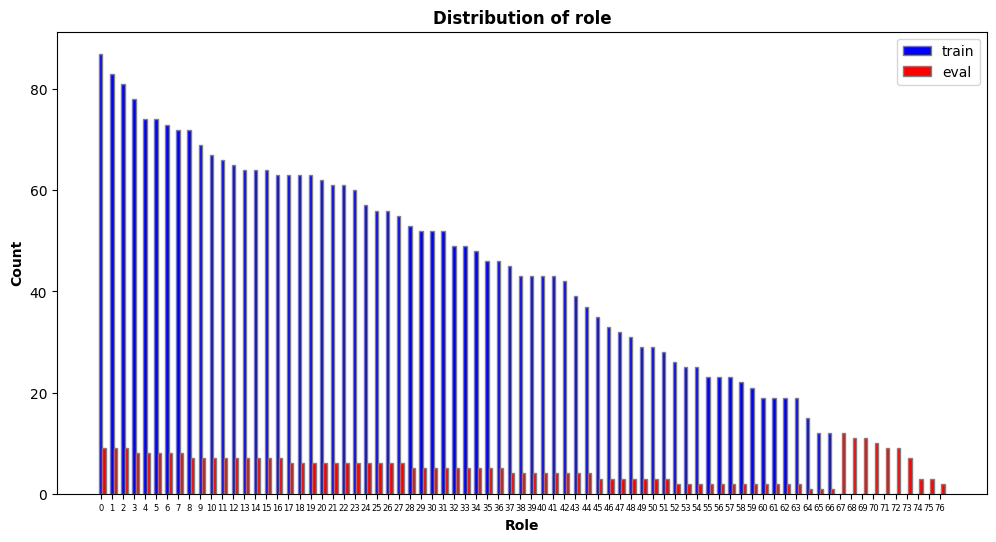

In [32]:
# 统计字段 'role' 的分布
train_role_counts = train_df['role'].value_counts()
eval_role_counts = eval_df['role'].value_counts()

role_list = list(role_to_id.keys())
train_role_counts_list = list(map(lambda x: train_role_counts.get(x, 0), role_list))
eval_role_counts_list = list(map(lambda x: eval_role_counts.get(x, 0), role_list))
        
barWidth = 0.3
r1 = np.arange(len(role_list))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))

plt.bar(r1, train_role_counts_list, color='b', width=barWidth, edgecolor='grey', label='train')
plt.bar(r2, eval_role_counts_list, color='r', width=barWidth, edgecolor='grey', label='eval')
# 添加标签
plt.title('Distribution of role', fontweight='bold')
plt.xlabel('Role', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r for r in range(len(role_list))], [role_to_id[rn] for rn in role_list], fontsize=6)

plt.legend()
plt.show()

训练数据及评估数据中对话轮次的数量分布对比

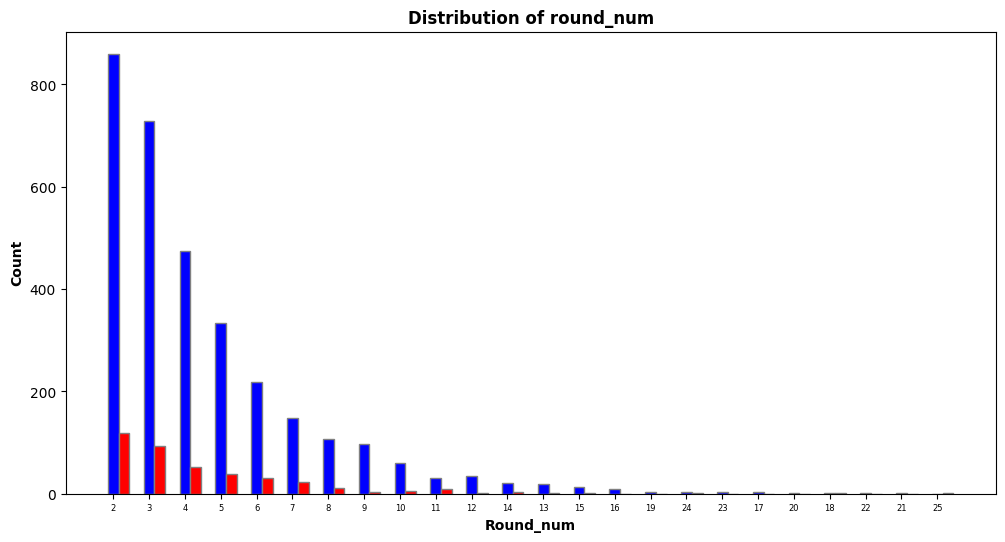

In [33]:
# 统计对话轮数的分布
train_round_num_counts = train_df['round_num'].value_counts()
eval_round_num_counts = eval_df['round_num'].value_counts()


barWidth = 0.3
r1 = np.arange(len(round_num_counts.index))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))

train_v = [train_round_num_counts.get(x, 0) for x in round_num_counts.index]
eval_v = [eval_round_num_counts.get(x, 0) for x in round_num_counts.index]
plt.bar(r1, train_v, color='b', width=barWidth, edgecolor='grey', label='train')
plt.bar(r2, eval_v, color='r', width=barWidth, edgecolor='grey', label='eval')
# 添加标签
plt.title('Distribution of round_num', fontweight='bold')
plt.xlabel('Round_num', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r for r in range(len(round_num_counts))], round_num_counts.index, fontsize=6)

plt.show()

In [11]:
train_df_new = train_df.drop(["role", "round_num"], axis=1)
eval_df_new = eval_df.drop(["role", "round_num"], axis=1)
train_data = train_df_new.to_dict('records')
eval_data = eval_df_new.to_dict('records')
random.seed(42)
# 打乱数据顺序
random.shuffle(train_data)
random.shuffle(eval_data)

In [12]:
with open("./data/train_ds.jsonl", "w", encoding="utf-8") as f:
    for d in train_data:
        f.write(json.dumps(d, ensure_ascii=False) + "\n")
with open("./data/eval_ds.jsonl", "w", encoding="utf-8") as f:
    for d in eval_data:
        f.write(json.dumps(d, ensure_ascii=False) + "\n")

## 3.2 微调训练

本案例基于 transformers 对 Meta-Llama-3-8B-Instruct 进行全量更新的微调训练。

Meta-Llama-3-8B-Instruct 下载地址：https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/tree/main

Meta-Llama-3-8B-Instruct Prompt format：https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3

Llama模型结构定义：https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py

In [13]:
from typing import List
import copy
import torch
import transformers
from datasets import load_dataset
from transformers import  AutoTokenizer, AutoModelForCausalLM

LLAMA3_TEMPLATE = "<|start_header_id|>user<|end_header_id|>\n\n{}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"


def preprocess(example, tokenizer, max_length, template=LLAMA3_TEMPLATE):
    """
    Preprocess a dialogue dataset into the format required by model.
    """
    srcs = example['src']
    tgts = example['tgt']
    result_inputs = []
    result_labels = []
    result_attention_mask = []
    for idx, (questions, answers) in enumerate(zip(srcs, tgts)):
        utterances = []
        for i, (src, tgt) in enumerate(zip(questions, answers)):
            if i == 0:
                utterances.append('<|begin_of_text|>' + template.format(src))
            else:
                utterances.append(template.format(src))
            utterances.append(tgt)
        utterances_ids = tokenizer(utterances,
                                   add_special_tokens=False,
                                   max_length=max_length,
                                   truncation=True).input_ids
        input_ids = []
        label = []  # 用于对input进行mask，只计算target部分的loss
        for i, utterances_id in enumerate(utterances_ids):
            if i % 2 == 0:
                # instruction
                input_ids += utterances_id
                # 对instruction对应的label进行mask
                label += ([-100] * len(utterances_id))
            else:
                # response
                input_ids += (utterances_id + [tokenizer.convert_tokens_to_ids("<|eot_id|>")])
                label += (utterances_id + [tokenizer.convert_tokens_to_ids("<|eot_id|>")])
    

        assert len(input_ids) == len(label)
        # 对长度进行截断
        input_ids = input_ids[:max_length]
        label = label[:max_length]
        attention_mask = [1] * len(input_ids)
        
        result_inputs.append(input_ids)
        result_labels.append(label)
        result_attention_mask.append(attention_mask)
    return dict(input_ids=result_inputs, labels=result_labels, attention_mask=result_attention_mask)


def train(
    # model/data params
    base_model: str = "./model/Meta-Llama-3-8B-Instruct", 
    max_seq_len: int = 8192,
    train_data_path: str = "./data/train_ds.jsonl",
    val_data_path: str = "./data/eval_ds.jsonl",
    output_dir: str = "./output/role_model/",
    micro_batch_size: int = 8,
    gradient_accumulation_steps: int = 1,
    num_epochs: int = 3,
    learning_rate: float = 3e-5,
    val_set_size: int = 10,
):
    device_map = "auto"
    # 加载模型
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        device_map=device_map,
        attn_implementation="flash_attention_2"
    )

    tokenizer = AutoTokenizer.from_pretrained(
        base_model
    )
    tokenizer.pad_token_id = 0

    if train_data_path.endswith(".json") or train_data_path.endswith(".jsonl"):
        train_ds = load_dataset("json", data_files=train_data_path)
    else:
        train_ds = load_dataset(train_data_path)
    
    
    if val_data_path is not None:
        if val_data_path.endswith(".json") or val_data_path.endswith(".jsonl"):
            val_ds = load_dataset("json", data_files=val_data_path)
        else:
            val_ds = load_dataset(val_data_path)
        train_ds = train_ds["train"]
        val_ds = val_ds["train"]
    else:
        #split thte data to train/val set
        train_val = trian_data["train"].train_test_split(
            test_size=val_set_size, shuffle=False, seed=42
        )
        train_ds = train_val["train"]
        val_ds = train_val["test"]
        
    
    train_data = train_ds.map(preprocess,
                              fn_kwargs={'tokenizer': tokenizer, 'max_length': max_seq_len,
                                         'template': LLAMA3_TEMPLATE},
                              batched=True, num_proc=16,
                              remove_columns=["src", "tgt"]
                              )
    val_data = val_ds.map(preprocess,
                          fn_kwargs={'tokenizer': tokenizer, 'max_length': max_seq_len,
                                     'template': LLAMA3_TEMPLATE},
                          batched=True, num_proc=16,
                          remove_columns=["src", "tgt"]
                          )   

    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=micro_batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=50,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            logging_steps=10,
            optim="adamw_torch",
            fp16=True,
            evaluation_strategy="steps",
            save_strategy="steps",
            eval_steps=500,
            save_steps=1000,
            output_dir=output_dir,
            save_total_limit=3
        ),
        data_collator=transformers.DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
        ),
    )

    trainer.train()
    model.save_pretrained(output_dir, max_shard_size="2GB") # 保存模型，且最大分片大小为 2GB
    tokenizer.save_pretrained(output_dir) # 保存 tokenizer


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
train(
    # model/data params
    base_model = "/mnt/cfs_bj/big_model/models/meta-llama/Meta-Llama-3-8B-Instruct/", 
    train_data_path= "./data/train_ds.jsonl",
    val_data_path  = "./data/eval_ds.jsonl",
    output_dir = "./output/role_model/",
    micro_batch_size = 2,
    gradient_accumulation_steps = 1,
    num_epochs = 3,
    learning_rate = 3e-5
)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes. No dtype was provided, you should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes. No dtype was provided, you should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator.
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.03s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Generating train split: 3175 examples [00:00, 71406.67 examples/s]
Generating train

Step,Training Loss,Validation Loss
500,2.511300,2.769120
1000,2.260000,2.192609
1500,1.740700,1.825378
2000,0.484200,1.751186
2500,0.344600,1.665199
3000,0.467600,1.483624
3500,0.050100,1.611675
4000,0.126400,1.606017
4500,0.058100,1.613451


Process ForkProcess-22:
Process ForkProcess-20:
Process ForkProcess-15:
Process ForkProcess-13:
Process ForkProcess-3:
Process ForkProcess-17:
Process ForkProcess-16:
Process ForkProcess-6:
Process ForkProcess-32:
Process ForkProcess-25:
Process ForkProcess-19:
Process ForkProcess-23:
Process ForkProcess-11:
Process ForkProcess-18:
Process ForkProcess-26:
Process ForkProcess-8:
Process ForkProcess-2:
Process ForkProcess-10:
Process ForkProcess-12:
Process ForkProcess-4:
Process ForkProcess-9:
Process ForkProcess-29:
Process ForkProcess-5:
Process ForkProcess-21:
Process ForkProcess-31:
Process ForkProcess-7:
Process ForkProcess-14:
Process ForkProcess-28:
Process ForkProcess-24:
Process ForkProcess-30:
Process ForkProcess-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rec

  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._targe

  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocess

## 3.3 模型评估
对微调训练好的模型进行评估，包含自动化测评和人工测评

### 3.3.1 自动化测评
计算预测结果与gt之间的ROUGE指标

In [15]:
import json
from tqdm import tqdm
from transformers import GenerationConfig

# 为演示流畅，此处对于多轮数据仅取最后一轮的输出进行评估
# 可根据需求将多轮数据拆分成多个数据进行评估
def read_test_data(path, template):
    """读取数据"""
    all_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            src = data["src"]
            tgt = data["tgt"]
            assert len(src) == len(tgt)
            prompt = ""
            response = ""
            for i, (p, r) in enumerate(zip(src, tgt)):
                if i < len(src) - 1:
                    if i == 0:
                        prompt += '<|begin_of_text|>' + template.format(p)
                    else:
                        prompt += template.format(p)
                    prompt += r + '<|eot_id|>'
                else:
                    prompt += template.format(p)
                    response += r
            item = {
                "prompt": prompt,
                "response": response
            }
                    
            all_data.append(item)
            
    return all_data


def get_model_resp(all_data, model, tokenizer):
    """获取模型预测结果"""
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    generation_config = GenerationConfig(
        temperature=0.9,
        top_p=0.7,
        top_k=40,
        num_beams=1,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        eos_token_id=terminators
    )

    new_data = []
    for data in tqdm(all_data, desc="模型预测"):
        prompt = data["prompt"]
        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to("cuda:0")
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=256,
        )
        s = generation_output.sequences[0]
        r_s = s[len(input_ids[0]):-1]
        result = tokenizer.decode(r_s)
        data["generate"] = result
        new_data.append(data)
        
    return new_data


In [16]:
tokenizer = AutoTokenizer.from_pretrained("./output/role_model/")
# 选择验证集loss最小的checkpoint
model = AutoModelForCausalLM.from_pretrained("./output/role_model/checkpoint-3000").to("cuda:0")

test_data = read_test_data("./data/eval_ds.jsonl", LLAMA3_TEMPLATE)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.37it/s]


In [17]:
eval_infer = get_model_resp(test_data, model, tokenizer)
with open('./data/infer_result.jsonl', 'w', encoding='utf-8') as f:
    for data in eval_infer:
        f.write(json.dumps(data, ensure_ascii=False) + '\n')

模型预测: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398/398 [07:08<00:00,  1.08s/it]


In [18]:
import json
from eval_functions import equal_eval, cover_eval, rouge_eval

# # 从本地读取预测结果
# eval_infer = []
# with open('./data/infer_result.jsonl', 'r', encoding='utf-8') as f:
#     for line in f:
#         d = json.loads(line)
#         eval_infer.append(d)

hypothesis = [d["generate"] for d in eval_infer]
reference = [d["response"] for d in eval_infer]
rouge_result = rouge_eval(hypothesis=hypothesis, reference=reference)

print("ROUGE：", rouge_result)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.598 seconds.
Prefix dict has been built successfully.


ROUGE： [{'name': 'rouge-1', 'value': 0.6094598621113209, 'description': 'rouge-1 指标平均得分'}, {'name': 'rouge-2', 'value': 0.49570650273917627, 'description': 'rouge-2 指标平均得分'}, {'name': 'rouge-l', 'value': 0.5860273652139303, 'description': 'rouge-l 指标平均得分'}]


### 3.3.2 人工测评

针对于评估集的生成结果，使用人工打分的方式对回答进行打分。

打分规则：

"4":完全可以扮演提问中的角色进行对话，回答完全符合角色口吻和身份，文本流畅语句通顺

"3":扮演了提问中正确的角色，回答完全符合角色口吻和身份，但文本不流畅或字数不满足要求

"2":扮演了提问中正确的角色，但是部分语句不符合角色口吻和身份，文本流畅语句通顺

"1":能够以角色的口吻和身份进行一部分对话，和角色设定有一定偏差，回答内容不流畅，或不满足文本字数要求

"0":扮演了错误的角色，没有扮演正确的角色，角色设定和提问设定差异极大，完全不满意

对评估集的样本一一打分之后，取平均值。

In [28]:
eval_infer[2]

{'prompt': "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{'姓名': '林萧', '性别': '女', '物种': '人类', '年龄': '25岁（故事结尾）', '工作': '文字工作者', '昵称': '萧萧', '生日': '3月4日', '身高': '168 cm', '体重': '45 kg', '生肖': '未知', '星座': '双鱼座', '居住地': '中国上海', '恋爱状态': '与简溪分手，与周崇光/陆烧重归于好', '爱好': '写作，阅读', '学历': '上海大学中文系', '经典台词': ['红颜薄命，丑女多福', '我受到了惊吓', '生活充满一千零一种未知的可能性。'], '人物经历': '林萧，主角，经历友情与爱情考验。性格温和善良，依赖他人。在神秘火灾中幸存。情绪真实，易心软，有小情绪，但因平凡朴素让人喜爱。', '人物关系': {'周崇光/陆烧': '男友，国家知名偶像作家', '简溪': '前任男友，因误会分手', '顾里': '多年好闺蜜，M·E广告部总监', '南湘': '多年好友，M·E设计部助理', '唐宛如': '好友，羽毛球运动员', 'Neil': '好姐妹，顾里的表弟，M·E法务部总监', '宫洺': '上司，周崇光异父异母的哥哥', '顾源': '闺蜜顾里的男朋友，简溪的死党兼姘头', 'Kitty': '工作伙伴，宫洺的助手', '林泉': '情敌，与简溪关系暧昧后离开'}, '喜欢的事情/东西': '文字，友谊', '不喜欢的事情/东西': '胆小怕事，没有主见'}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演林萧进行对话。\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n好的！现在我来扮演林萧。<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n顾源：（翻白眼）我去他家打PS3。而且，你那个‘也’字是什么意思？是在抱怨我之前和你们家简溪一直‘搞’在一起是吧？<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

# 4. 总结

1. 在构建训练数据时候，根据应用场景补充详细的背景信息，可以进一步提升模型的效果。如在角色扮演的场景中，通过增加详细的人设设定，包含基本信息和角色特点，充分激发大模型能力。
2. 选择不同的模型微调时候，需要注意原始模型的chat模版，按照原始模型的chat模版对自定义数据集进行格式化。
3. 训练数据和评估数据切分，需要尽量满足：评估集的数据和训练数据来源一致，但是内容不能重复；数据分布尽量一致；增加未出现在训练集中的类型，用于测评模型泛化能力。
4. 微调训练时，注意训练集和验证集的loss变化，选择验证集上loss低的checkpoint模型进行后续评估及部署。